# **PDP - Partial Dependence Plots**

In [1]:
import pickle
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib.dates as mdates
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap
from itertools import repeat, chain
import seaborn as sns
import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics import mean_squared_error, mean_absolute_error
import lightgbm
from lightgbm import LGBMRegressor
import shap
import scipy.sparse

import alibi

style.use('seaborn-v0_8-ticks')
plt.rcParams.update({'figure.facecolor':'white'})
sns.set_theme(style="ticks")

import os
from pathlib import Path

# Store the original directory path in a global variable if it doesn't exist yet
if not hasattr(__builtins__, '_original_dir'):
    __builtins__._original_dir = os.getcwd()
    root_dir = Path(__builtins__._original_dir).resolve().parent
    os.chdir(root_dir)
    print(f"Changed working directory to: {os.getcwd()}")
else:
    print(f"Directory already changed. Current working directory: {os.getcwd()}")

from utils.data_preparation import preprocess_data, split_data, mapping, determine_unit
from processing.custom_metrics import nash_sutcliffe, kling_gupta

Changed working directory to: C:\Users\xkorpijo3\OneDrive - Fortum\Desktop\Master-thesis-GBRT-dam


### Define target/model of analysis

In [4]:
target_name = 'GV51'
model_name = 'LightGBM'

In [5]:
features = ['h', 'h_MA_060', 'h_MA_180',
            'TA', 'TA_MA_180', 'TA_lag_060', 'TA_lag_090', 
            'P', 'P_RS_180',
            'Q', 'Q_RS_030', 'Q_RS_120',
            't', 'month']

In [9]:
test_size = 0.2
poly_degree = 0

if target_name in features: features.remove(target_name)
path = f'./data/LOS_DAMM_{mapping(target_name)}.csv'
data = pd.read_csv(path, sep=';', parse_dates=['Date-Time'])

# Extract start and end dates
dates = data['Date-Time']
start_date = dates.iloc[0].date()  # First date (YYYY-MM-DD)
end_date = dates.iloc[-1].date()  # Last date (YYYY-MM-DD)

# Preprocess the data (You would need to define preprocess_data elsewhere in your code)
X, y, dates = preprocess_data(features, target_name, start_date, end_date, poly_degree=poly_degree, test_size=test_size)

# Split the data into training and testing sets (Assumes split_data is defined elsewhere)
X_train, X_test, y_train, y_test, split_index = split_data(X, y, test_size=test_size)

print("data loaded")

with open(f'./visualization/models/{model_name}/{model_name}_model_{target_name}.pkl', 'rb') as f:
    model = pickle.load(f)

print(f"{target_name} {model_name} loaded")

# # Due to lagged variables, remove first 90 days
# X = X[90*24:]
# X_train = X_train[90*24:]

# y = y[90*24:]
# y_train = y_train[90*24:]

data loaded
GV51 LightGBM loaded


In [10]:
model.fit(X_train, y_train)

LGBMRegressor(colsample_bytree=0.8552996267089586,
              learning_rate=0.03286202028083, linear_tree=False, max_depth=6,
              min_split_gain=0.6280661793078444, n_estimators=2951,
              num_leaves=3, reg_alpha=2.5137862899800223,
              reg_lambda=3.9430716192876, subsample=0.49235297280952,
              verbose=-1)

In [12]:
print("Feature names:")
print(X.columns, '\n')

train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)
all_predictions = model.predict(X)

rmse_train = np.sqrt(mean_squared_error(y_train, train_predictions))
rmse_test = np.sqrt(mean_squared_error(y_test, test_predictions))
mae_test = mean_absolute_error(y_test, test_predictions)
KGE_test = kling_gupta(y_test, test_predictions)

print("RMSE Train:", rmse_train)
print("RMSE Test:", rmse_test)
print("MAE Test:", mae_test)
print("KGE Test:", KGE_test)

Feature names:
Index(['t', 'month', 'h', 'h_MA_060', 'h_MA_180', 'TA', 'TA_MA_180',
       'TA_lag_060', 'TA_lag_090', 'P', 'P_RS_180', 'Q', 'Q_RS_030',
       'Q_RS_120'],
      dtype='object') 

RMSE Train: 0.15384411588778826
RMSE Test: 0.5383597627773131
MAE Test: 0.4368273770811632
KGE Test: 0.9471330536560743


## PDP

In [ ]:
import mpl_toolkits.mplot3d  # Unused but required import for doing 3d projections with matplotlib < 3.2
from sklearn.inspection import partial_dependence
from sklearn.inspection import PartialDependenceDisplay

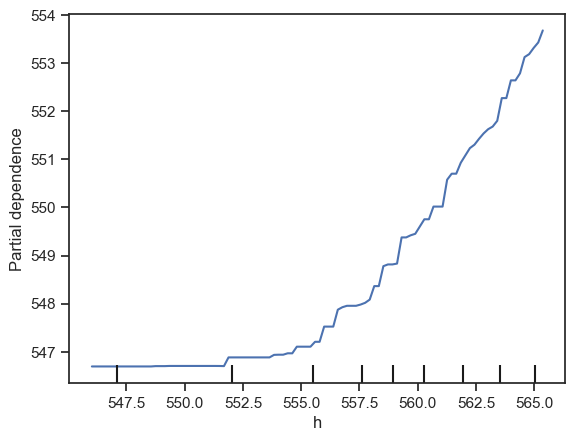

In [ ]:
PartialDependenceDisplay.from_estimator(
    estimator=model,
    X=X,
    features=['h']
)

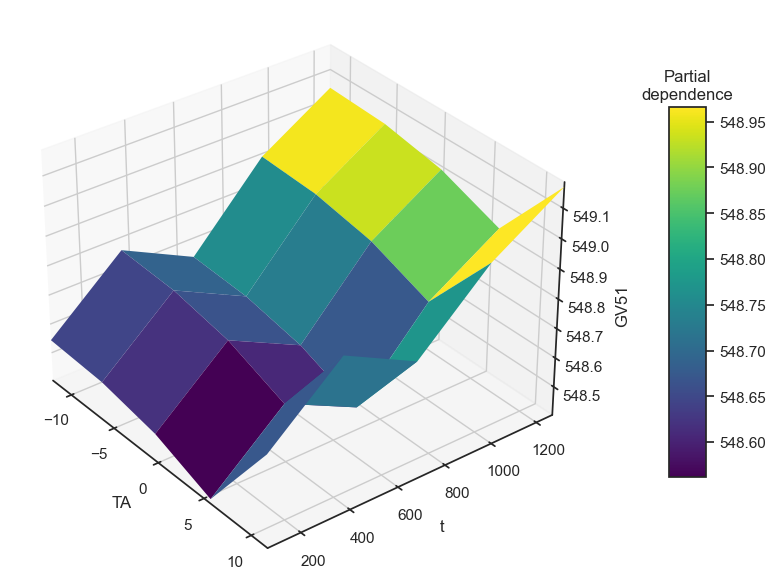

In [36]:
fig = plt.figure(figsize=(10, 8))

# features = ("TA", "t")
# pdp = partial_dependence(
#     model, X_train, features=features, kind="average", grid_resolution=5
# )
XX, YY = np.meshgrid(pdp["grid_values"][0], pdp["grid_values"][1])
Z = pdp.average[0].T

ax = fig.add_subplot(projection="3d")
fig.add_axes(ax)

surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap=plt.cm.viridis, edgecolor="none")
ax.set_xlabel(features[0])
ax.set_ylabel(features[1])
ax.set_zlabel(target_name, labelpad=5, rotation=90)

# pretty init view
ax.view_init(elev=32, azim=142)

clb = plt.colorbar(surf, pad=0.12, shrink=0.6, aspect=10)
clb.ax.set_title("Partial\ndependence")

# After creating your plot but before plt.show()
x_min = XX.min()
x_max = XX.max()

y_min = YY.min()
y_max = YY.max()

# Reverse the x-axis by setting limits in reverse order
ax.set_xlim(x_max, x_min)
ax.set_ylim(y_max, y_min)

plt.show()

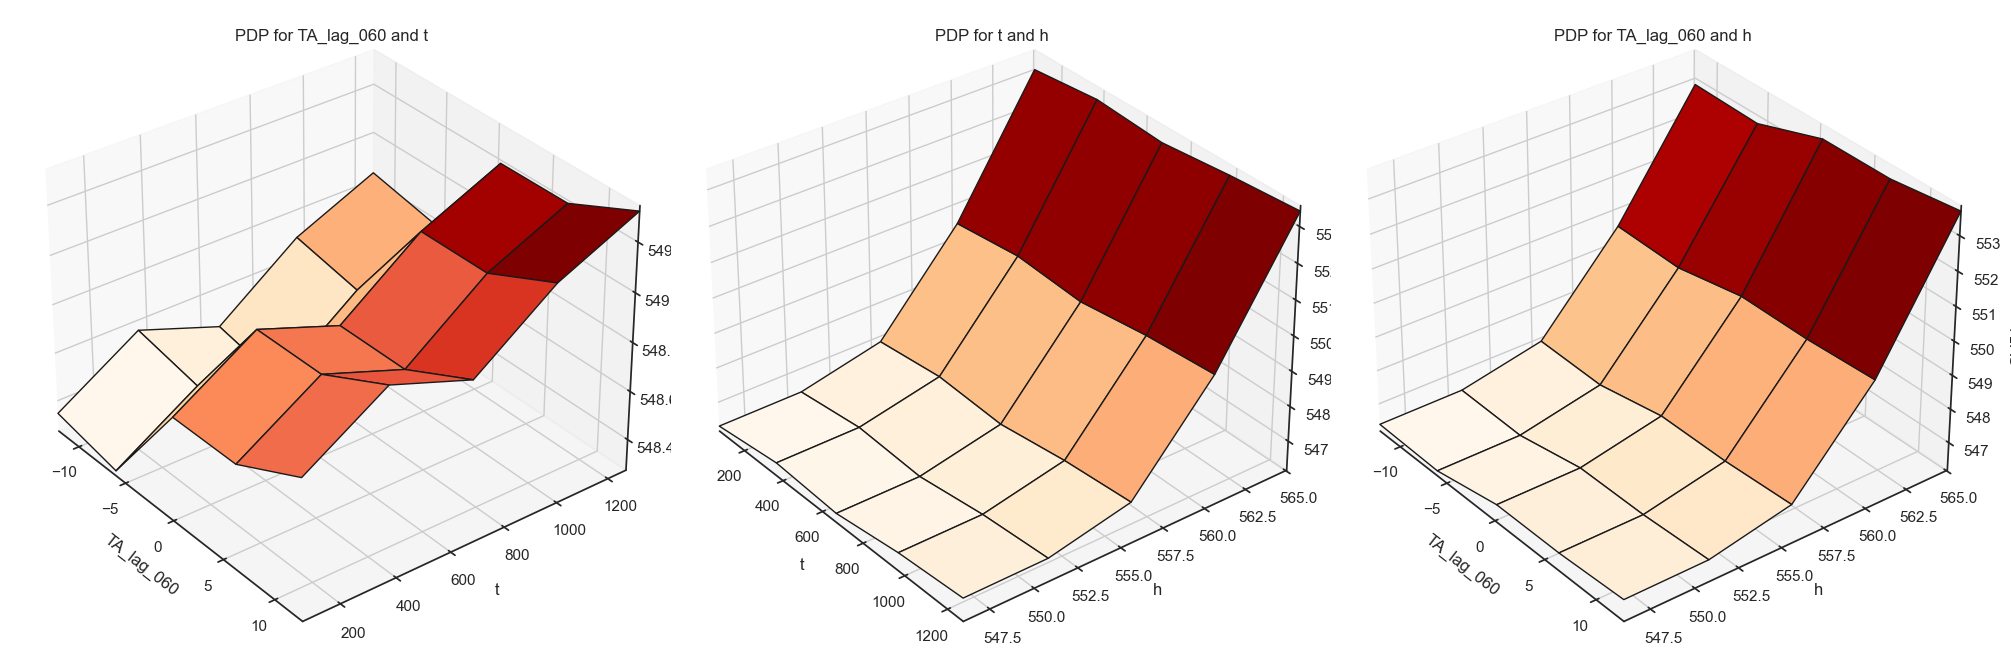

In [42]:
# import matplotlib.pyplot as plt
# import numpy as np
# from sklearn.inspection import partial_dependence

# Create figure with 3 subplots in a row
fig = plt.figure(figsize=(20, 8))  # Wider figure to accommodate 3 plots

# Define the feature pairs for each subplot
feature_pairs = [
    ("TA_lag_060", "t"),       # First subplot features
    ("t", "h"),      # Second subplot features
    ("TA_lag_060", "h")       # Third subplot features
]

# # Common settings for all subplots
# common_settings = {
#     'cmap': plt.cm.viridis,
#     'edgecolor': 'none',
#     'rstride': 1,
#     'cstride': 1
# }
common_settings = {
    'cmap': plt.cm.OrRd,
    'edgecolor': 'k',
    'rstride': 1,
    'cstride': 1
}
# surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap=plt.cm.OrRd, edgecolor="k")

# Create each subplot
for i, features in enumerate(feature_pairs):
    # Calculate partial dependence for current feature pair
    pdp = partial_dependence(
        model, X_train, features=features, kind="average", grid_resolution=5
    )
    
    # Create meshgrid
    XX, YY = np.meshgrid(pdp["grid_values"][0], pdp["grid_values"][1])
    Z = pdp.average[0].T
    
    # Create subplot in position i+1
    ax = fig.add_subplot(1, 3, i+1, projection="3d")
    
    # Create the surface plot
    surf = ax.plot_surface(XX, YY, Z, **common_settings)
    
    # Set labels
    ax.set_xlabel(features[0])
    ax.set_ylabel(features[1])
    ax.set_zlabel(target_name, labelpad=5, rotation=90)
    
    # Set view angle
    ax.view_init(elev=32, azim=142)
    
    # Reverse axes if needed
    x_min, x_max = XX.min(), XX.max()
    y_min, y_max = YY.min(), YY.max()
    ax.set_xlim(x_max, x_min)
    ax.set_ylim(y_max, y_min)
    
    # Add colorbar for each subplot
    # clb = plt.colorbar(surf, ax=ax, pad=0.12, shrink=0.6, aspect=10)
    # clb.ax.set_title("Partial\ndependence")
    
    # Add a title for each subplot
    ax.set_title(f"PDP for {features[0]} and {features[1]}", y=1.02)

# Add a main title for the entire figure
# fig.suptitle(f"Partial Dependence Plots for {target_name}", fontsize=16, y=0.98)

# Adjust layout
plt.tight_layout()
# plt.subplots_adjust(top=0.85)  # Make room for the main title

plt.show()

In [ ]:
fig = plt.figure(figsize=(10, 8))

features = ("TA", "t")
pdp = partial_dependence(
    model, X_train, features=features, kind="average", grid_resolution=5
)
XX, YY = np.meshgrid(pdp["grid_values"][0], pdp["grid_values"][1])
Z = pdp.average[0].T

ax = fig.add_subplot(projection="3d")
fig.add_axes(ax)

surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap=plt.cm.viridis, edgecolor="none")
ax.set_xlabel(features[0])
ax.set_ylabel(features[1])
ax.set_zlabel(target_name, labelpad=5, rotation=90)

# pretty init view
ax.view_init(elev=32, azim=142)

clb = plt.colorbar(surf, pad=0.12, shrink=0.6, aspect=10)
clb.ax.set_title("Partial\ndependence")

# After creating your plot but before plt.show()
x_min = XX.min()
x_max = XX.max()

y_min = YY.min()
y_max = YY.max()

# Reverse the x-axis by setting limits in reverse order
ax.set_xlim(x_max, x_min)
ax.set_ylim(y_max, y_min)

plt.show()